In [2]:
import tensorflow as tf
import json
import numpy as np
import cv2

import matplotlib.pyplot as plt

from cell_division.nets.transfer_learning import CNN
from auxiliary.data.dataset_cell import CellDataset
from auxiliary import values as v
from auxiliary.utils.colors import bcolors as c

# from focal_loss import SparseCategoricalFocalLoss
from tensorflow.keras.losses import CategoricalCrossentropy
from cell_division.nets.custom_layers import w_cel_loss, focal_loss

from sklearn.utils.class_weight import compute_class_weight

# GPU config
from auxiliary.utils.timer import LoadingBar
from auxiliary.gpu.gpu_tf import (
    increase_gpu_memory, 
    set_gpu_allocator, 
    clear_session
)

increase_gpu_memory()
set_gpu_allocator()

In [19]:
img_dir = v.data_path + 'CellDivision/images/'
label_train_dir = v.data_path + 'CellDivision/train.csv'
label_test_dir = v.data_path + 'CellDivision/test.csv'
label_val_dir = v.data_path + 'CellDivision/val.csv'

INPUT_SHAPE = (50, 50, 3)
BATCH_SIZE = 16

Dataset (Generators)

Generatos do not load directly the images into memory, but they load the images on the fly. This is useful when the dataset is too large to fit into memory.

In [20]:
train_generator = CellDataset(
    img_dir, 
    label_train_dir, 
    batch_size=BATCH_SIZE, 
    resize=INPUT_SHAPE[:2]
)

val_generator = CellDataset(
    img_dir, 
    label_val_dir, 
    batch_size=BATCH_SIZE, 
    resize=INPUT_SHAPE[:2]
)

Transfer Learning 

In [5]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (np.integer, np.int64, np.int32, np.int16, np.int8)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float64, np.float32, np.float16)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)): 
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

In [24]:
base_models = {
    # 'DenseNet121': tf.keras.applications.DenseNet121,
    # 'EfficientNetV2L': tf.keras.applications.EfficientNetV2L,
    'EfficientNetV2M': tf.keras.applications.EfficientNetV2M,
    'VGG16': tf.keras.applications.VGG16,
    'ResNet50': tf.keras.applications.ResNet50,
    'InceptionV3': tf.keras.applications.InceptionV3,
    'MobileNetV2': tf.keras.applications.MobileNetV2,
    'NASNetMobile': tf.keras.applications.NASNetMobile,
}


In [26]:
param_grid = {
    'base_model': list(base_models.keys()),
    'lr': [1e-3, 1e-2],
    'fine_tune': [True, False],
    'loss': [focal_loss(), w_cel_loss()],
    'top': ['CAM', 'Standard'],
    # 'class_weight': [None, 'balanced']
}

In [ ]:
bar = LoadingBar(
    len(param_grid['base_model']) * len(param_grid['lr']) * len(param_grid['fine_tune']) * len(param_grid['loss']) * len(param_grid['top'])
)

results = {}

for base_model in param_grid['base_model']:
    for lr in param_grid['lr']:
        for fine_tune in param_grid['fine_tune']:
            for loss in param_grid['loss']:
                for top in param_grid['top']:
                    print(f'{c.OKGREEN}Model: {base_model} - LR: {lr} - Fine Tune: {fine_tune} - Loss: {loss} - Top: {top}{c.ENDC}')
                    
                    try:
                        model = CNN(
                            base=base_models[base_model],
                            n_classes=3,
                            input_shape=INPUT_SHAPE,
                            fine_tune=fine_tune
                        )
                        model.build_top(activation='softmax', b_type=top)
                        model.compile(lr=lr, loss=loss)
                        model.fit(
                            train_generator,
                            val_generator,
                            epochs=100,
                            batch_size=BATCH_SIZE,
                            save=False,
                            verbose=1
                        )
    
                        results[
                            str((base_model, lr, fine_tune, loss.__name__, top))
                        ] = model.model.history.history
                    except Exception as e:
                        print(f'{c.FAIL}Error:{c.ENDC} {e}')
                        results[(base_model, lr, fine_tune, loss, top)] = None

                    clear_session()
                    bar.update()
                    
    with open(f'../cell_division/results/{base_model}.json', 'w') as f:
        json.dump(results, f, cls=NumpyEncoder)
    results = {}

bar.end()

Model: EfficientNetV2M - LR: 0.001 - Fine Tune: True - Loss: <function focal_loss.<locals>.focal_loss_fixed at 0x7460d413ec20> - Top: CAM
Epoch 1/100
48/48 [==============================] - 60s 750ms/step - loss: 0.6676 - auc: 0.6400 - val_loss: 0.4677 - val_auc: 0.4919 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 11s 236ms/step - loss: 0.0918 - auc: 0.7642 - val_loss: 0.0731 - val_auc: 0.7070 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 11s 229ms/step - loss: 0.0849 - auc: 0.8035 - val_loss: 0.1057 - val_auc: 0.7411 - lr: 0.0010
Epoch 4/100
48/48 [==============================] - ETA: 0s - loss: 0.0742 - auc: 0.7168
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
48/48 [==============================] - 11s 226ms/step - loss: 0.0742 - auc: 0.7168 - val_loss: 0.0866 - val_auc: 0.5017 - lr: 0.0010
Epoch 5/100
48/48 [==============================] - 11s 235ms/step - loss: 0.0490 - auc: 0.8159 - val_loss: 0.0672 - v

2024-08-05 09:57:21.487730: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 135856128 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 23592960/8169717760
2024-08-05 09:57:21.487770: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      8589934592
InUse:                      1037651165
MaxInUse:                   4867033686
NumAllocs:                    16085260
MaxAllocSize:               3760193536
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-08-05 09:57:21.487949: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-08-05 09:57:21.487966: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.

25/48 [==============>...............] - ETA: 4s - loss: 1.0374 - auc: 0.6751

2024-08-05 09:57:21.689573: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 135856128 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 23592960/8169717760
2024-08-05 09:57:21.689604: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      8589934592
InUse:                      1037651165
MaxInUse:                   4867033686
NumAllocs:                    16089691
MaxAllocSize:               3760193536
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-08-05 09:57:21.689740: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-08-05 09:57:21.689749: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.

26/48 [===============>..............] - ETA: 4s - loss: 1.0372 - auc: 0.6750

2024-08-05 09:57:21.892294: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 134217728 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 23592960/8169717760
2024-08-05 09:57:21.892324: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      8589934592
InUse:                      1240766957
MaxInUse:                   4867033686
NumAllocs:                    16092255
MaxAllocSize:               3760193536
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-08-05 09:57:21.892491: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-08-05 09:57:21.892500: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.

28/48 [================>.............] - ETA: 3s - loss: 1.0381 - auc: 0.6731

2024-08-05 09:57:22.242171: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 134217728 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 23592960/8169717760
2024-08-05 09:57:22.242211: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      8589934592
InUse:                      1188093933
MaxInUse:                   4867033686
NumAllocs:                    16099789
MaxAllocSize:               3760193536
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-08-05 09:57:22.242394: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-08-05 09:57:22.242410: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.

 Best model: ("('DenseNet121', 0.01, False, 'focal_loss_fixed', 'Standard')", 0.8529568910598755)
 Val AUC: 0.8529568910598755


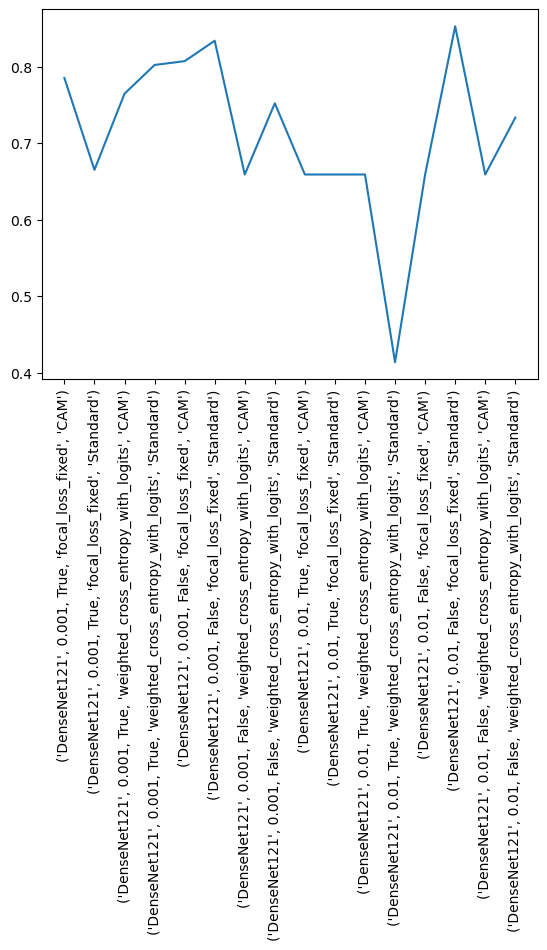

In [17]:
results_dense = json.load(open('../cell_division/results/DenseNet121.json'))
results_efficient_l = json.load(open('../cell_division/results/EfficientNetV2L.json'))

def plot_results(results):
    import matplotlib.pyplot as plt
    
    val_aucs = []
    for key, value in results.items():
        if value:
            val_aucs.append((key, max(value['val_auc'])))
        
    
    print(f'{c.OKGREEN} Best model: {c.ENDC}{max(val_aucs, key=lambda x: x[1])}')
    print(f'{c.OKGREEN} Val AUC: {c.ENDC}{max([x[1] for x in val_aucs])}')
    
    plt.plot([x[1] for x in val_aucs])
    plt.xticks(range(len(val_aucs)), [name for name in results.keys()], rotation=90)
    plt.show()
    
plot_results(results_dense)

 Best model: ("('EfficientNetV2L', 0.001, True, 'focal_loss_fixed', 'CAM')", 0.8522130250930786)
 Val AUC: 0.8522130250930786


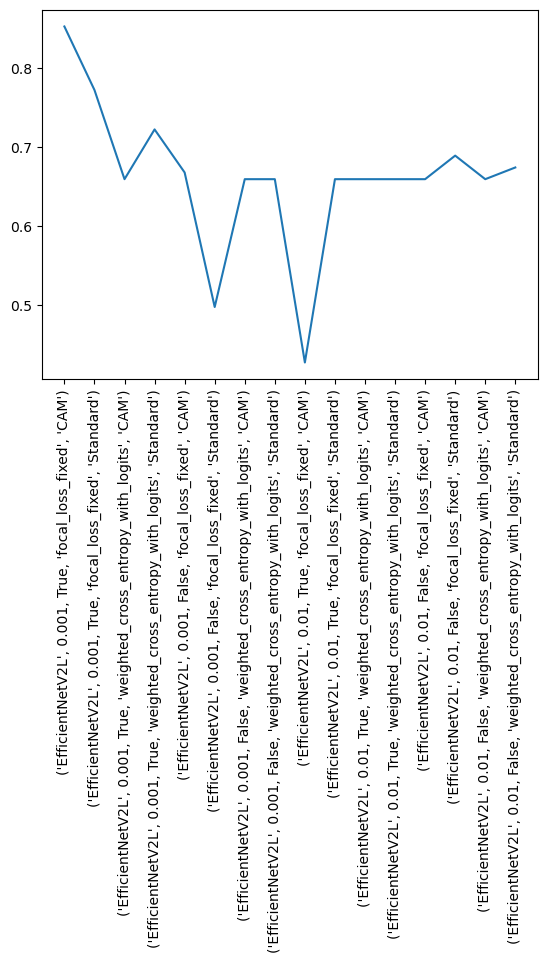

In [18]:
plot_results(results_efficient_l)